## Another model

### Set up environment

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
from ddeint import ddeint

### Stim functions

In [15]:
# Input functions
def rect(T):
    """
    create a centered rectangular pulse of width $T
    """
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, shape):
    """
    create a train of pulses over $t at times $at and shape $shape
    """

    return np.sum(shape(t - at[:,np.newaxis]), axis=0)

### System

In [16]:
def nonuniform(X, t, d, omegas, gains, nonunifs, I):
    # Set initial conditions and params 
    theta0,theta1,theta2 = X(t)
    theta0d,theta1d,theta2d, = X(t-d)
    
    w0,w1,w2 = omegas
    k1,k2 = gains
    a0,a1,a2 = nonunifs
    
    # Input signal (Optional, currently not interacting with system)
    d_theta0 = w0 + a0*np.sin(theta0)
    
    # First layer
    d_theta1 = w1 + a1*(1+np.sin(theta2))*np.sin(theta1) + k1*I(t)*np.cos(theta1)
    
    # Second layer  
    d_theta2 = w2 + a2*np.sin(theta2) + k2*np.sin(theta1-theta1d) 
     
    return np.array([d_theta0, d_theta1, d_theta2])

### Parameters

In [17]:
# Initial Conditions
thetas = lambda tt: np.array([1, 2, 3])

# Delay used for layer 2
d = 5

# Parameter values
frequencies = frequency0, frequency1, frequency2 = 3, 4, 15
w0 = (frequency0*2*np.pi/1000)
w1 = (frequency1*2*np.pi/1000)
w2 = (frequency2*2*np.pi/1000)
k1,k2 = 0.3, 0.5
a0,a1,a2 = 0.2*w0, 0.2*w1, 0.2*w2

omegas = [w0,w1,w2]
gains = [k1,k2]
nonunifs = [a0,a1,a2]

# time series
tstart = 0.0
tend = 5000
tnum = 10000
tstep = (tend-tstart) / tnum
t = np.linspace(tstart, tend, tnum)

# stimulus
stim_start = 500
ptime   = 2000
onsets1 = np.arange(stim_start,ptime,333)
onsets2 = np.arange(ptime,tend,400)
perturb = np.concatenate([onsets1,onsets2])
sig = pulse_train(
    t,              # time domain
    at=perturb,     # times of pulses
    shape=rect(5)  # shape of pulse
)

# interpolate stimulus for ODE
I = UnivariateSpline(t, sig)
I.set_smoothing_factor(0)

# Combine args
args = (d,omegas,gains,nonunifs,I)

### Solve

In [18]:
# solve
sol = ddeint(nonuniform, thetas, t, fargs=args)
S = sol[:,0]
X = sol[:,1]
Y = sol[:,2]

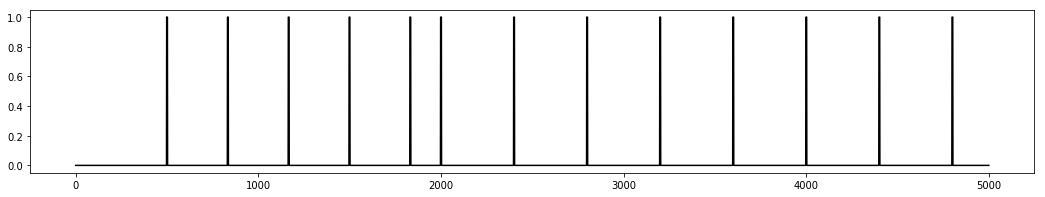

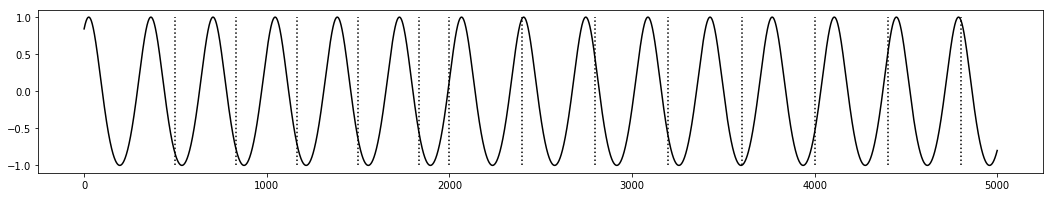

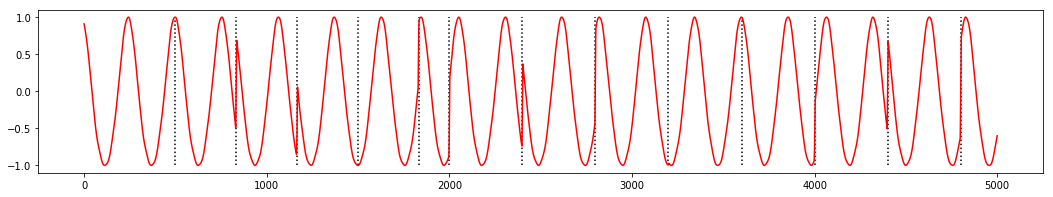

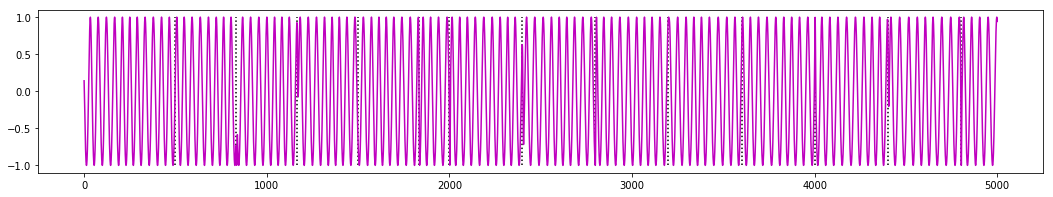

In [19]:
figsize = (18,3)

# Plot stimulus 
plt.figure(figsize=figsize)
plt.plot(t,I(t),'k')

# Plot sinusoidal stimulus (NOT IN SYSTEM)
plt.figure(figsize=figsize)
plt.vlines(perturb,min(np.sin(S)),max(np.sin(S)),linestyles='dotted')
plt.plot(t,np.sin(S),'k')

# Plot Layer 1
plt.figure(figsize = figsize)
plt.vlines(perturb,min(np.sin(X)),max(np.sin(X)),linestyles='dotted')
plt.plot(t,np.sin(X),'r')

# Plot layer 2
plt.figure(figsize = figsize)
plt.vlines(perturb,min(np.sin(Y)),max(np.sin(Y)),linestyles='dotted')
plt.plot(t,np.sin(Y),'m')